## Putting it all together: Building a value-weighted index

This chapter combines the previous concepts by teaching you how to create a value-weighted index. This index uses market-cap data contained in the stock exchange listings to calculate weights and 2016 stock price information. Index performance is then compared against benchmarks to evaluate the performance of the index you created.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Explore and clean company listing information

To get started with the construction of a market-value based index, you'll work with the combined listing info for the three largest US stock exchanges, the NYSE, the NASDAQ and the AMEX.

In this and the next exercise, you will calculate market-cap weights for these stocks.

In [12]:
nyse = pd.read_excel('listings.xlsx', sheet_name='nyse', na_values = 'n/a')
nyse.insert(0, 'Exchange', 'nyse')

nasdaq = pd.read_excel('listings.xlsx', sheet_name='nasdaq', na_values = 'n/a')
nasdaq.insert(0, 'Exchange', 'nasdaq')

amex = pd.read_excel('listings.xlsx', sheet_name='amex', na_values = 'n/a')
amex.insert(0, 'Exchange', 'amex')

listings = pd.concat([nyse, nasdaq, amex], axis=0)
listings['Market Capitalization'] /= 1e6 # in Million USD

# Inspect listings
print(listings.info())

# Move 'stock symbol' into the index
listings.set_index('Stock Symbol', inplace=True)

# Drop rows with missing 'sector' data
listings.dropna(subset=['Sector'], inplace=True)

# Select companies with IPO Year before 2019
listings = listings[listings['IPO Year'] < 2019]

# Inspect the new listings data
print(listings.info())

# Show the number of companies per 'Sector' using .groupby() and .size(). 
# Sort the output in descending order.
print(listings.groupby('Sector').size().sort_values(ascending=False))



<class 'pandas.core.frame.DataFrame'>
Int64Index: 6674 entries, 0 to 359
Data columns (total 8 columns):
Exchange                 6674 non-null object
Stock Symbol             6674 non-null object
Company Name             6674 non-null object
Last Sale                6590 non-null float64
Market Capitalization    6674 non-null float64
IPO Year                 2852 non-null float64
Sector                   5182 non-null object
Industry                 5182 non-null object
dtypes: float64(3), object(5)
memory usage: 469.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, WBAI to ZDGE
Data columns (total 7 columns):
Exchange                 2349 non-null object
Company Name             2349 non-null object
Last Sale                2349 non-null float64
Market Capitalization    2349 non-null float64
IPO Year                 2349 non-null float64
Sector                   2349 non-null object
Industry                 2349 non-null object
dtypes: float64(3), object(4)
memory

### Select and inspect index components

Now that you have imported and cleaned the `listings` data, you can proceed to select the `index` components as the largest company for each sector by market capitalization.

You'll also have the opportunity to take a closer look at the components, their last market value, and last price.

In [14]:
# Use .groupby() and .nlargest() to select the largest company by 'Market Capitalization' for each 'Sector'
components = listings.groupby(['Sector'])['Market Capitalization'].nlargest(1)

# Print components, sorted by market cap
print(components.sort_values(ascending=False))

# Select stock symbols and print the result
tickers = components.index.get_level_values('Stock Symbol')
print(tickers)

# Print company name, market cap, and last price for each component 
info_cols = ['Company Name', 'Market Capitalization', 'Last Sale']
display(listings.loc[tickers, info_cols].sort_values('Market Capitalization', ascending=False))

Sector                 Stock Symbol
Technology             AAPL            740024.467000
Consumer Services      AMZN            422138.530626
Miscellaneous          BABA            275525.000000
Health Care            AMGN            118927.210535
Transportation         UPS              90180.886756
Finance                GS               88840.590477
Consumer Non-Durables  ABEV             88240.198455
Basic Industries       RIO              70431.476895
Public Utilities       TEF              54609.806092
Capital Goods          GM               50086.335099
Energy                 PAA              22223.001416
Consumer Durables      CPRT             13620.922869
Name: Market Capitalization, dtype: float64
Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')


,Company Name,Market Capitalization,Last Sale
Stock Symbol,,,
AAPL,Apple Inc.,740024.467000,141.05
AMZN,"Amazon.com, Inc.",422138.530626,884.67
BABA,Alibaba Group Holding Limited,275525.000000,110.21
AMGN,Amgen Inc.,118927.210535,161.61
UPS,"United Parcel Service, Inc.",90180.886756,103.74
GS,"Goldman Sachs Group, Inc. (The)",88840.590477,223.32
ABEV,Ambev S.A.,88240.198455,5.62
RIO,Rio Tinto Plc,70431.476895,38.94
TEF,Telefonica SA,54609.806092,10.84


### Import index component price information

Now you'll use the stock symbols for the companies you selected in the last exercise to calculate returns for each company.

['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF', 'AAPL', 'UPS']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1762 non-null float64
GS      1762 non-null float64
ILMN    1761 non-null float64
MA      1762 non-null float64
PAA     1762 non-null float64
RIO     1762 non-null float64
TEF     1762 non-null float64
UPS     1762 non-null float64
dtypes: float64(12)
memory usage: 179.0 KB
None


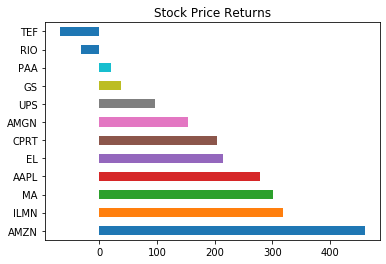

In [22]:
print(tickers)

# Import prices and inspect result
stock_prices = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=['Date'])
print(stock_prices.info())

# Calculate the returns  for the index components by dividing the last row of stock_prices by the first, subtracting 1 and multiplying by 100.
price_return = stock_prices.iloc[-1,:].div(stock_prices.iloc[0,:]).sub(1).mul(100)

# Plot horizontal bar chart of sorted price_return   
price_return.sort_values(ascending=False).plot(kind='barh', title='Stock Price Returns')

### Calculate number of shares outstanding

The next step towards building a value-weighted index is to calculate the number of shares for each index component.

The number of shares will allow you to calculate the total market capitalization for each component given the historical price series in the next exercise.

In [24]:
# Use .loc[] with the list of tickers to select the index components and the columns 'Market Capitalization' and 'Last Sale'
components = listings.loc[tickers, ['Market Capitalization', 'Last Sale']]

# Print the first rows of components
display(components.head())

# Calculate the number of shares by dividing Market Capitalization by 'Last Sale'
no_shares = components['Market Capitalization'].div(components['Last Sale'])

# Print the sorted no_shares
display(no_shares.sort_values(ascending=False))


,Market Capitalization,Last Sale
Stock Symbol,,
RIO,70431.476895,38.94
GM,50086.335099,33.39
CPRT,13620.922869,29.65
ABEV,88240.198455,5.62
AMZN,422138.530626,884.67


Stock Symbol
ABEV    15701.102928
AAPL     5246.540000
TEF      5037.804990
BABA     2500.000000
RIO      1808.717948
GM       1500.039985
UPS       869.297154
AMGN      735.890171
PAA       723.404994
AMZN      477.170618
CPRT      459.390316
GS        397.817439
dtype: float64

### Create time series of market value

You can now use the number of shares to calculate the total market capitalization for each component and trading date from the historical price series.

The result will be the key input to construct the value-weighted stock index, which you will complete in the next exercise.

Stock Symbol
AAPL    5246.540000
TEF     5037.804990
RIO     1808.717948
MA      1108.884100
UPS      869.297154
AMGN     735.890171
PAA      723.404994
AMZN     477.170618
CPRT     459.390316
GS       397.817439
EL       366.405816
ILMN     146.300000
Name: Number of Shares, dtype: float64


,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
Date,,,,,,,,,,,,
2010-01-04,160386.7278,42475.580670,63893.145750,2090.225938,8892.669154,68854.242342,4469.465,28476.143688,19531.934838,101342.466626,143829.332465,50575.708420
2010-01-05,160701.5202,42107.635585,64270.110538,2090.225938,8859.692631,70071.563705,4440.205,28398.521801,19748.956336,102916.051241,143728.576365,50662.638135
2010-01-06,158130.7156,41791.202811,63105.814231,2081.038131,8885.341038,69323.666920,4713.786,28343.077596,19741.722286,106063.220471,142217.234868,50288.840359
2010-01-07,157815.9232,41408.539922,62032.180340,2067.256422,8998.926841,70680.224387,4794.251,28154.567299,19502.998638,106081.307650,139799.088473,49906.349611
2010-01-08,158865.2312,41776.485008,63711.820915,2076.444228,9035.567423,69343.557792,4849.845,28165.656140,19568.105088,107256.974316,138892.283574,52305.609756


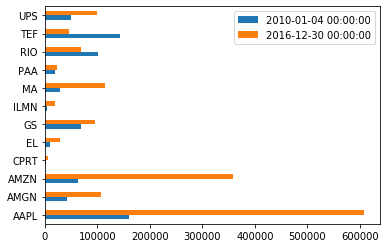

In [32]:
components = pd.read_csv('components.csv', index_col='Stock Symbol')
no_shares = components['Number of Shares']
print(no_shares.sort_values(ascending=False))

# Multiply stock_prices by no_shares to create a time series of market cap per ticker, 
# and assign it to market_cap
market_cap = stock_prices.mul(no_shares)
display(market_cap.head())

# Select first and last market cap here
first_value = market_cap.iloc[0,:]
last_value = market_cap.iloc[-1,:]


# Use pd.concat() to concatenate first_value and last_value along axis=1 
# and plot the result as horizontal bar chart
pd.concat([first_value, last_value], axis=1).plot(kind='barh')


### Calculate & plot the composite index

By now you have all ingredients that you need to calculate the aggregate stock performance for your group of companies.

Use the time series of market capitalization that you created in the last exercise to aggregate the market value for each period, and then normalize this series to convert it to an index.

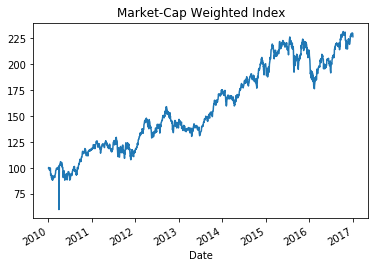

In [39]:
# Aggregate and print the market cap per trading day
raw_index = market_cap.sum(axis=1)

# Normalize the aggregate market cap here 
index = raw_index.div(raw_index.iloc[0]).mul(100)

# Plot the index here
index.plot(title='Market-Cap Weighted Index')
plt.show()

### Calculate the contribution of each stock to the index

You have successfully built the value-weighted index. Let's now explore how it performed over the 2010-2016 period.

Let's also determine how much each stock has contributed to the index return.

126.65826661173818
Stock Symbol
CPRT    0.007564
PAA     0.012340
ILMN    0.014110
EL      0.017282
TEF     0.030324
RIO     0.039110
GS      0.049332
UPS     0.050077
AMGN    0.066039
MA      0.068484
AMZN    0.234410
AAPL    0.410929
Name: Market Capitalization, dtype: float64


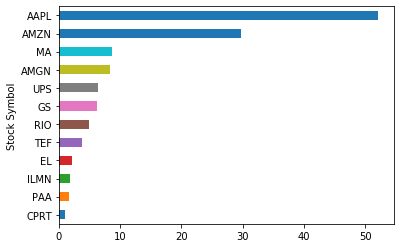

In [40]:
# Calculate and print the index return here
# Divide the last index value by the first, subtract 1 and multiply by 100. 
index_return = (index.iloc[-1] / index.iloc[0] - 1) * 100
print(index_return)

# Select the market capitalization
market_cap = components['Market Capitalization']

# Calculate the total market cap
total_market_cap = market_cap.sum()

# Calculate the component weights, and print the result
# Divide the components' market cap by total_market_cap to calculate the component weights
weights = market_cap.div(total_market_cap)
print(weights.sort_values())

# Calculate and plot the contribution by component
# Multiply weights by the index_return to calculate the contribution by component, 
# sort the values in ascending order, 
# and plot the result as a horizontal bar chart.
weights.mul(index_return).sort_values().plot(kind='barh')

### Compare index performance against benchmark I

The next step in analyzing the performance of your index is to compare it against a benchmark.

In the video, we used the S&P 500 as benchmark. You can also use the Dow Jones Industrial Average, which contains the 30 largest stocks, and would also be a reasonable benchmark for the largest stocks from all sectors across the three exchanges.

Index    126.658267
DJIA      86.722172
dtype: float64


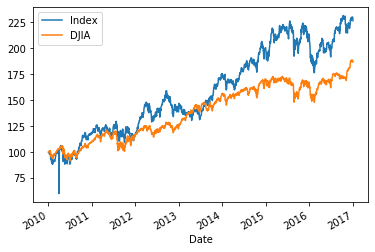

In [64]:
djia = pd.read_csv('djia.csv', parse_dates=['date'], index_col='date').dropna()['djia']
djia = djia['2010-01-04':]

# Convert index series to dataframe here
data = index.to_frame('Index')

# Normalize djia series and add as new column to data
djia = djia.div(djia[0]).mul(100)
data['DJIA'] = djia

# Show total return for both index and djia by dividing the last row of data by the first, subtracting 1 and multiplying by 100.
print(data.iloc[-1,:].div(data.iloc[0,:]).sub(1).mul(100))

# Plot both series
data.plot()

### Compare index performance against benchmark II

C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if __name__ == '__main__':


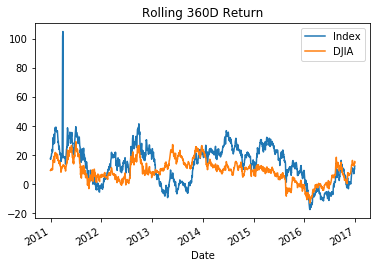

In [66]:
import numpy as np
# Define a function multi_period_return that takes a numpy array of period returns as input, 
# and returns the total return for the period. 
# Use the formula from the video - add 1 to the input, pass the result to np.prod(), subtract 1 and multiply by 100.
def multi_period_return(r):
    return (np.prod(1+r)-1) * 100

# Calculate rolling_return_360
rolling_return_360 = data.pct_change().rolling(window='360D').apply(multi_period_return)

# Plot rolling_return_360 here
rolling_return_360.plot(title='Rolling 360D Return')


### Visualize your index constituent correlations

To better understand the characteristics of your index constituents, you can calculate the return correlations.

Use the daily stock prices or your index companies, and show a heatmap of the daily return correlations!

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1762 non-null float64
GS      1762 non-null float64
ILMN    1761 non-null float64
MA      1762 non-null float64
PAA     1762 non-null float64
RIO     1762 non-null float64
TEF     1762 non-null float64
UPS     1762 non-null float64
dtypes: float64(12)
memory usage: 259.0 KB
None
          AAPL      AMGN      AMZN      CPRT        EL        GS      ILMN  \
AAPL  1.000000  0.286898  0.327611  0.346616  0.306770  0.344981  0.264791   
AMGN  0.286898  1.000000  0.323408  0.355892  0.349893  0.390076  0.336927   
AMZN  0.327611  0.323408  1.000000  0.298929  0.334031  0.333402  0.242726   
CPRT  0.346616  0.355892  0.298929  1.000000  0.371763  0.423160  0.265665   
EL    0.306770  0.349893  0.334031  0.371763  1.000000  0.358318  0.214027   

Text(0.5, 1, 'Daily Return Correlations')

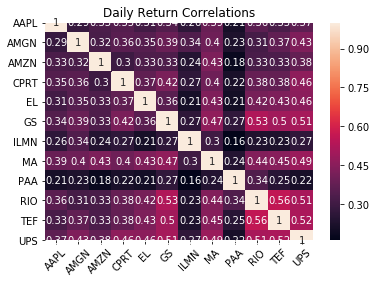

In [68]:
import seaborn as sns

# Inspect stock_prices here
print(stock_prices.info())

# Calculate the daily returns
returns = stock_prices.pct_change()

# Calculate and print the pairwise correlations
correlations = returns.corr()
print(correlations)

# Plot a heatmap of daily return correlations
sns.heatmap(correlations, annot=True)
plt.xticks(rotation=45)
plt.title('Daily Return Correlations')

### Save your analysis to multiple excel worksheets

Now that you have completed your analysis, you may want to save all results into a single Excel workbook.

Let's practice exporting various DataFrame to multiple Excel worksheets.

In [71]:
# Inspect index and stock_prices
#print(index.info())
print(stock_prices.info())

# Join index to stock_prices, and inspect the result
data = stock_prices.join(index.to_frame('Index'))
print(data.info())

# Create index & stock price returns
returns = data.pct_change()

# Export data and data as returns to excel
with pd.ExcelWriter('my_saved_data.xls') as writer:
    data.to_excel(excel_writer=writer, sheet_name='data')
    returns.to_excel(excel_writer=writer, sheet_name='returns')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1762 non-null float64
GS      1762 non-null float64
ILMN    1761 non-null float64
MA      1762 non-null float64
PAA     1762 non-null float64
RIO     1762 non-null float64
TEF     1762 non-null float64
UPS     1762 non-null float64
dtypes: float64(12)
memory usage: 259.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 13 columns):
AAPL     1761 non-null float64
AMGN     1761 non-null float64
AMZN     1761 non-null float64
CPRT     1761 non-null float64
EL       1762 non-null float64
GS       1762 non-null float64
ILMN     1761 non-null float64
MA       1762 non-null float64
PAA      1762 non-null float64
RIO      1762 non-null float64
TEF      1762 non-null float64
U